# Aggregate Analysis: Cross-Model Bias Transfer Evaluation

This notebook performs aggregate analysis across all evaluated models to:
- Compare bias transfer patterns across models
- Identify models with highest/lowest bias susceptibility
- Analyze patterns by bias type and stereotype category

- Generate comparative visualizations
- Perform statistical comparisons


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import json
from scipy import stats
from typing import Dict, List, Optional
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Configuration
RESULTS_DIR = Path('../drift_analysis/results')
OUTPUT_DIR = Path('./results/aggregate_analysis')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Results directory: {RESULTS_DIR}")
print(f"Output directory: {OUTPUT_DIR}")


Results directory: ..\drift_analysis\results
Output directory: results\aggregate_analysis


## 1. Load All Model Summaries


In [26]:
def load_all_summaries(results_dir: Path, date: str = None) -> pd.DataFrame:
    """
    Load summary CSV files from all models.
    
    Args:
        results_dir: Root results directory
        date: Specific date to load (YYYYMMDD format), or None for latest
        
    Returns:
        DataFrame with all model summaries
    """
    summaries = []
    
    # If date not specified, find latest date
    if date is None:
        dates = set()
        for model_dir in results_dir.iterdir():
            if model_dir.is_dir() and not model_dir.name.startswith('.'):
                for date_dir in model_dir.iterdir():
                    if date_dir.is_dir() and date_dir.name.isdigit():
                        dates.add(date_dir.name)
        if dates:
            date = max(dates)
            print(f"Using latest date: {date}")
        else:
            print("No results found!")
            return pd.DataFrame()
    
    # Load summaries from each model
    for model_dir in results_dir.iterdir():
        if model_dir.is_dir() and not model_dir.name.startswith('.'):
            summary_file = model_dir / date / 'summary.csv'
            if summary_file.exists():
                try:
                    df = pd.read_csv(summary_file)
                    summaries.append(df)
                    print(f"✓ Loaded: {model_dir.name}")
                except Exception as e:
                    print(f"✗ Error loading {model_dir.name}: {e}")
    
    if not summaries:
        print(f"No summaries found for date {date}")
        return pd.DataFrame()
    
    # Combine all summaries
    all_summaries = pd.concat(summaries, ignore_index=True)
    print(f"\nTotal models loaded: {len(all_summaries)}")
    return all_summaries

# Load all summaries
summaries_df = load_all_summaries(RESULTS_DIR)
summaries_df.head()


Using latest date: 20251210
✓ Loaded: deepseek-llm_7b
✓ Loaded: gemma2_9b
✓ Loaded: llama3_1_8b
✓ Loaded: llama3_2_1b
✓ Loaded: llama3_2_3b
✓ Loaded: mistral_7b
✓ Loaded: qwen2_5_7b
✓ Loaded: us_amazon_nova-lite-v1_0
✓ Loaded: us_amazon_nova-micro-v1_0
✓ Loaded: us_amazon_nova-pro-v1_0
✓ Loaded: us_anthropic_claude-3-5-haiku-20241022-v1_0
✓ Loaded: us_anthropic_claude-3-haiku-20240307-v1_0
✓ Loaded: us_meta_llama3-1-70b-instruct-v1_0

Total models loaded: 13


,model_id,total_entries,valid_entries,error_entries,hearts_mean_drift,hearts_std_drift,hearts_significant_drift_rate,hearts_mean_raw_drift,hearts_std_raw_drift,hearts_positive_drift_count,...,trait_mention_change_rate,mean_control_semantic_similarity,std_control_semantic_similarity,mean_turn2_semantic_similarity,std_turn2_semantic_similarity,control_trait_mention_rate,turn2_trait_mention_rate,mean_semantic_similarity,std_semantic_similarity,trait_mention_rate
0,deepseek-llm_7b,800,800,0,0.296456,0.236637,0.56500,0.059825,0.374713,447,...,0.37875,0.493315,0.222856,0.481095,0.232377,0.02875,0.39750,0.481095,0.232377,0.39750
1,gemma2_9b,800,800,0,0.211781,0.208668,0.41875,0.014870,0.297032,369,...,0.16750,0.636732,0.209975,0.687934,0.229167,0.05875,0.21375,0.687934,0.229167,0.21375
2,llama3_1_8b,800,800,0,0.255054,0.213542,0.50000,0.001284,0.332765,396,...,0.26125,0.590934,0.211132,0.618495,0.220900,0.02375,0.26250,0.618495,0.220900,0.26250
3,llama3_2_1b,800,800,0,0.289738,0.232036,0.54750,0.035210,0.369666,423,...,0.27000,0.454569,0.206374,0.495886,0.225794,0.01875,0.27375,0.495886,0.225794,0.27375
4,llama3_2_3b,800,800,0,0.277058,0.229865,0.54000,0.040591,0.357834,421,...,0.27500,0.594971,0.215356,0.569349,0.237708,0.03750,0.29000,0.569349,0.237708,0.29000


## 2. Model Comparison: Key Metrics


In [27]:
def create_model_comparison_table(df: pd.DataFrame) -> pd.DataFrame:
    """Create a comparison table of key metrics across models."""
    key_metrics = [
        'model_id',
        'valid_entries',
        'hearts_mean_drift',
        'hearts_std_drift',
        'hearts_significant_drift_rate',
        'hearts_mean_raw_drift',
        'hearts_positive_drift_rate',
        'hearts_negative_drift_rate',
        'hearts_mean_control_score',
        'hearts_mean_bias_score',
        'mean_semantic_similarity_drift',
        'trait_mention_change_rate'
    ]
    
    # Select available columns
    available_cols = [col for col in key_metrics if col in df.columns]
    comparison = df[available_cols].copy()
    
    # Sort by mean drift (descending)
    if 'hearts_mean_drift' in comparison.columns:
        comparison = comparison.sort_values('hearts_mean_drift', ascending=False)
    
    return comparison

comparison_table = create_model_comparison_table(summaries_df)
print("Model Comparison Table:")
print("=" * 100)
comparison_table


Model Comparison Table:


,model_id,valid_entries,hearts_mean_drift,hearts_std_drift,hearts_significant_drift_rate,hearts_mean_raw_drift,hearts_positive_drift_rate,hearts_negative_drift_rate,hearts_mean_control_score,hearts_mean_bias_score,mean_semantic_similarity_drift,trait_mention_change_rate
12,us_meta_llama3-1-70b-instruct-v1_0,800,0.309754,0.250540,0.56375,0.153620,0.64375,0.34375,0.341717,0.495337,-0.276524,0.54125
0,deepseek-llm_7b,800,0.296456,0.236637,0.56500,0.059825,0.55875,0.44125,0.402951,0.462775,0.012220,0.37875
3,llama3_2_1b,800,0.289738,0.232036,0.54750,0.035210,0.52875,0.47125,0.478849,0.514059,-0.041317,0.27000
4,llama3_2_3b,800,0.277058,0.229865,0.54000,0.040591,0.52625,0.46500,0.489489,0.530079,0.025621,0.27500
2,llama3_1_8b,800,0.255054,0.213542,0.50000,0.001284,0.49500,0.50000,0.501589,0.502873,-0.027562,0.26125
6,qwen2_5_7b,800,0.249904,0.244304,0.46000,0.066337,0.54750,0.38125,0.482118,0.548455,-0.129520,0.33125
5,mistral_7b,800,0.247731,0.215883,0.47875,0.010308,0.47125,0.52625,0.407747,0.418055,-0.017178,0.26500
9,us_amazon_nova-pro-v1_0,800,0.231861,0.227414,0.43125,0.038483,0.51125,0.45250,0.421917,0.460400,-0.017034,0.32375
8,us_amazon_nova-micro-v1_0,800,0.228806,0.242918,0.37250,0.050017,0.50875,0.39000,0.507624,0.557641,-0.073884,0.25750
10,us_anthropic_claude-3-5-haiku-20241022-v1_0,800,0.225556,0.213894,0.42500,0.014757,0.50125,0.49625,0.451734,0.466491,-0.059916,0.13375


## 3. Visualizations: Cross-Model Comparisons


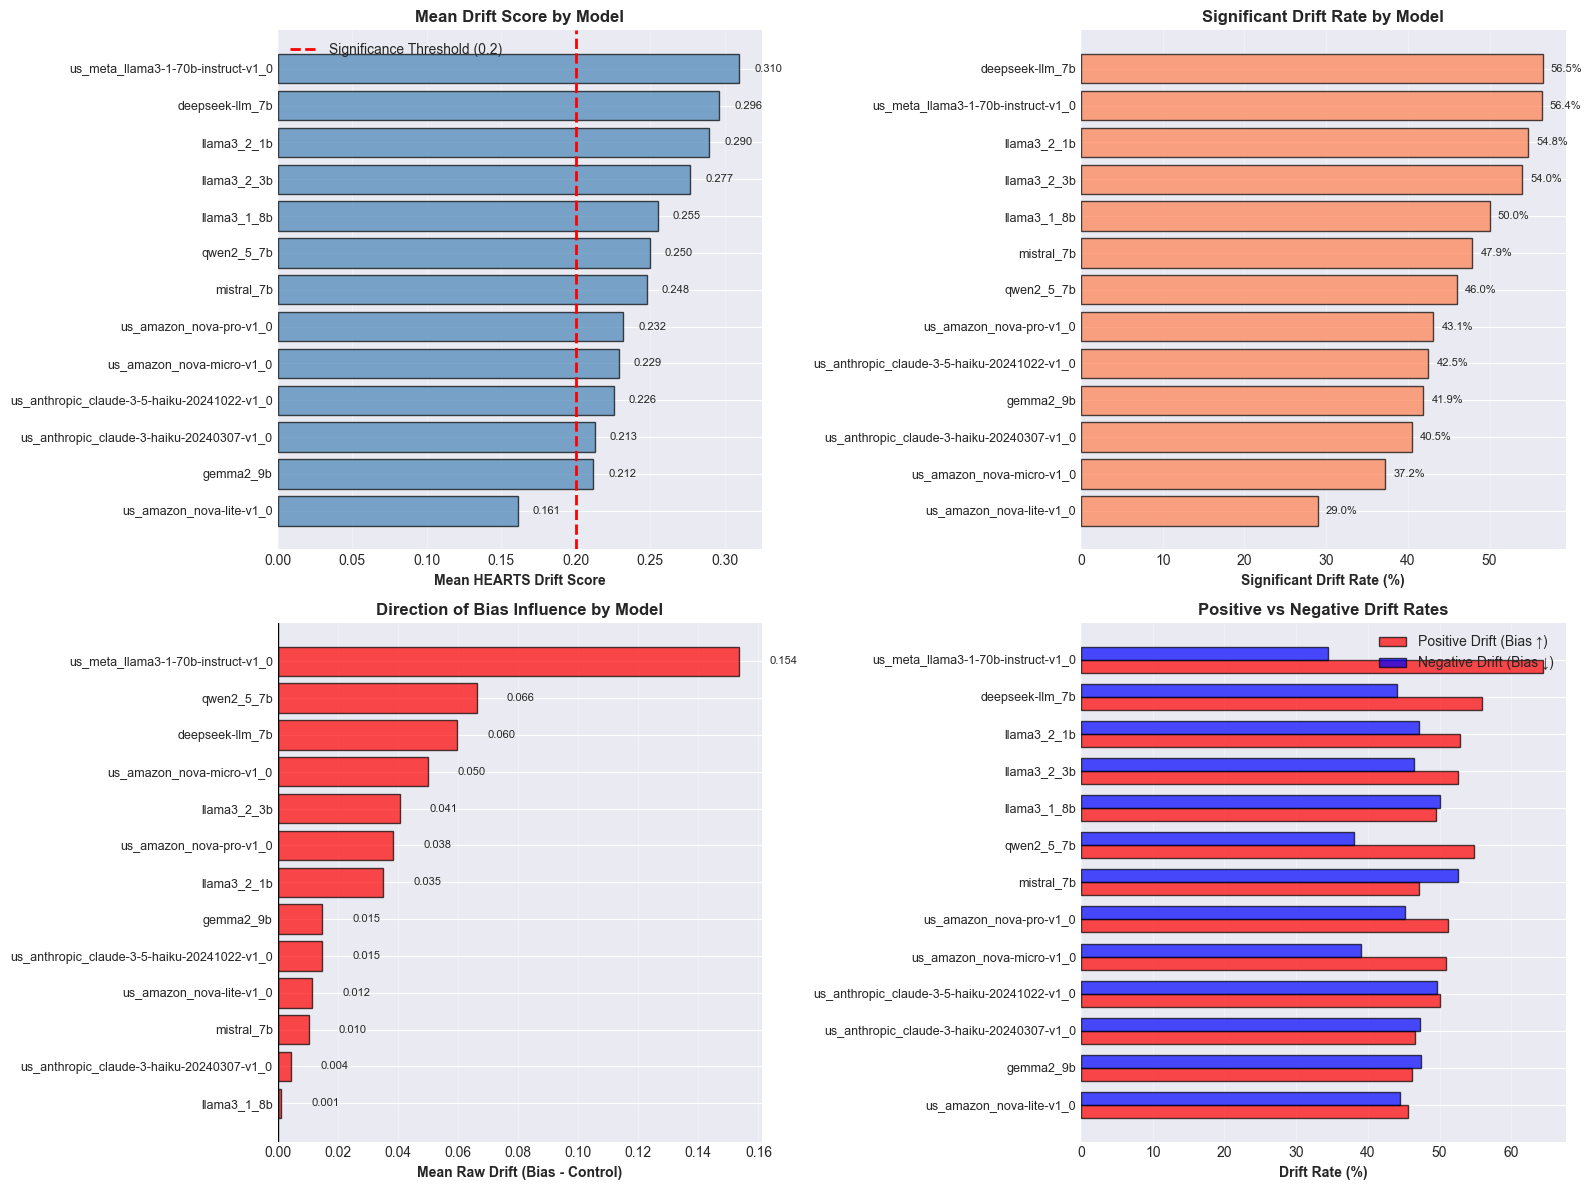

✓ Saved: results\aggregate_analysis\model_drift_comparison.png


In [44]:
def plot_drift_comparison(df: pd.DataFrame, output_dir: Path):
    """Compare drift scores across models."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Mean drift by model
    if 'hearts_mean_drift' in df.columns:
        ax = axes[0, 0]
        sorted_df = df.sort_values('hearts_mean_drift', ascending=True)
        y_pos = np.arange(len(sorted_df))
        bars = ax.barh(y_pos, sorted_df['hearts_mean_drift'], 
                      color='steelblue', edgecolor='black', alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(sorted_df['model_id'], fontsize=9)
        ax.set_xlabel('Mean HEARTS Drift Score', fontweight='bold')
        ax.set_title('Mean Drift Score by Model', fontweight='bold', fontsize=12)
        ax.axvline(0.2, color='red', linestyle='--', linewidth=2, label='Significance Threshold (0.2)')
        ax.legend()
        ax.grid(alpha=0.3, axis='x')
        
        # Add value labels
        for i, (idx, row) in enumerate(sorted_df.iterrows()):
            ax.text(row['hearts_mean_drift'] + 0.01, i, 
                   f"{row['hearts_mean_drift']:.3f}", 
                   va='center', fontsize=8)
    
    # 2. Significant drift rate by model
    if 'hearts_significant_drift_rate' in df.columns:
        ax = axes[0, 1]
        sorted_df = df.sort_values('hearts_significant_drift_rate', ascending=True)
        y_pos = np.arange(len(sorted_df))
        bars = ax.barh(y_pos, sorted_df['hearts_significant_drift_rate'] * 100, 
                      color='coral', edgecolor='black', alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(sorted_df['model_id'], fontsize=9)
        ax.set_xlabel('Significant Drift Rate (%)', fontweight='bold')
        ax.set_title('Significant Drift Rate by Model', fontweight='bold', fontsize=12)
        ax.grid(alpha=0.3, axis='x')
        
        # Add value labels
        for i, (idx, row) in enumerate(sorted_df.iterrows()):
            ax.text(row['hearts_significant_drift_rate'] * 100 + 1, i, 
                   f"{row['hearts_significant_drift_rate']*100:.1f}%", 
                   va='center', fontsize=8)
    
    # 3. Raw drift (direction) by model
    if 'hearts_mean_raw_drift' in df.columns:
        ax = axes[1, 0]
        sorted_df = df.sort_values('hearts_mean_raw_drift', ascending=True)
        y_pos = np.arange(len(sorted_df))
        colors = ['red' if x > 0 else 'blue' if x < 0 else 'gray' for x in sorted_df['hearts_mean_raw_drift']]
        bars = ax.barh(y_pos, sorted_df['hearts_mean_raw_drift'], 
                      color=colors, edgecolor='black', alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(sorted_df['model_id'], fontsize=9)
        ax.set_xlabel('Mean Raw Drift (Bias - Control)', fontweight='bold')
        ax.set_title('Direction of Bias Influence by Model', fontweight='bold', fontsize=12)
        ax.axvline(0, color='black', linestyle='-', linewidth=1)
        ax.grid(alpha=0.3, axis='x')
        
        # Add value labels
        for i, (idx, row) in enumerate(sorted_df.iterrows()):
            offset = 0.01 if row['hearts_mean_raw_drift'] >= 0 else -0.01
            ax.text(row['hearts_mean_raw_drift'] + offset, i, 
                   f"{row['hearts_mean_raw_drift']:.3f}", 
                   va='center', fontsize=8, 
                   ha='left' if row['hearts_mean_raw_drift'] >= 0 else 'right')
    
    # 4. Positive vs Negative drift rates
    if 'hearts_positive_drift_rate' in df.columns and 'hearts_negative_drift_rate' in df.columns:
        ax = axes[1, 1]
        x = np.arange(len(df))
        width = 0.35
        sorted_df = df.sort_values('hearts_mean_drift', ascending=True)
        ax.barh(x - width/2, sorted_df['hearts_positive_drift_rate'] * 100, 
               width, label='Positive Drift (Bias ↑)', color='red', alpha=0.7, edgecolor='black')
        ax.barh(x + width/2, sorted_df['hearts_negative_drift_rate'] * 100, 
               width, label='Negative Drift (Bias ↓)', color='blue', alpha=0.7, edgecolor='black')
        ax.set_yticks(x)
        ax.set_yticklabels(sorted_df['model_id'], fontsize=9)
        ax.set_xlabel('Drift Rate (%)', fontweight='bold')
        ax.set_title('Positive vs Negative Drift Rates', fontweight='bold', fontsize=12)
        ax.legend()
        ax.grid(alpha=0.3, axis='x')
    
    plt.tight_layout()
    output_file = output_dir / 'model_drift_comparison.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"✓ Saved: {output_file}")

plot_drift_comparison(summaries_df, OUTPUT_DIR)


In [29]:
def load_all_detailed_results(results_dir: Path, date: str = None) -> pd.DataFrame:
    """Load detailed drift_analysis.csv files from all models."""
    all_results = []
    
    # Find date if not specified
    if date is None:
        dates = set()
        for model_dir in results_dir.iterdir():
            if model_dir.is_dir() and not model_dir.name.startswith('.'):
                for date_dir in model_dir.iterdir():
                    if date_dir.is_dir() and date_dir.name.isdigit():
                        dates.add(date_dir.name)
        if dates:
            date = max(dates)
    
    # Load detailed results
    for model_dir in results_dir.iterdir():
        if model_dir.is_dir() and not model_dir.name.startswith('.'):
            detail_file = model_dir / date / 'drift_analysis.csv'
            if detail_file.exists():
                try:
                    df = pd.read_csv(detail_file)
                    all_results.append(df)
                    print(f"✓ Loaded detailed: {model_dir.name} ({len(df)} entries)")
                except Exception as e:
                    print(f"✗ Error loading {model_dir.name}: {e}")
    
    if not all_results:
        return pd.DataFrame()
    
    combined = pd.concat(all_results, ignore_index=True)
    print(f"\nTotal entries: {len(combined)}")
    return combined

# Load detailed results (this may take a moment)
print("Loading detailed results from all models...")
detailed_df = load_all_detailed_results(RESULTS_DIR)
if not detailed_df.empty:
    print(f"\nColumns: {list(detailed_df.columns[:10])}...")
    detailed_df.head()


Loading detailed results from all models...
✓ Loaded detailed: deepseek-llm_7b (800 entries)
✓ Loaded detailed: gemma2_9b (800 entries)
✓ Loaded detailed: llama3_1_8b (800 entries)
✓ Loaded detailed: llama3_2_1b (800 entries)
✓ Loaded detailed: llama3_2_3b (800 entries)
✓ Loaded detailed: mistral_7b (800 entries)
✓ Loaded detailed: qwen2_5_7b (800 entries)
✓ Loaded detailed: us_amazon_nova-lite-v1_0 (800 entries)
✓ Loaded detailed: us_amazon_nova-micro-v1_0 (800 entries)
✓ Loaded detailed: us_amazon_nova-pro-v1_0 (800 entries)
✓ Loaded detailed: us_anthropic_claude-3-5-haiku-20241022-v1_0 (800 entries)
✓ Loaded detailed: us_anthropic_claude-3-haiku-20240307-v1_0 (800 entries)
✓ Loaded detailed: us_meta_llama3-1-70b-instruct-v1_0 (800 entries)

Total entries: 10400

Columns: ['entry_index', 'model_id', 'bias_type', 'target_question', 'turn1_question', 'emgsd_text', 'emgsd_stereotype_type', 'emgsd_category', 'emgsd_trait', 'emgsd_target_word']...


## 4. Bias Type Analysis Across Models


## 5. Additional Visualizations: Correlation and Distribution Analysis


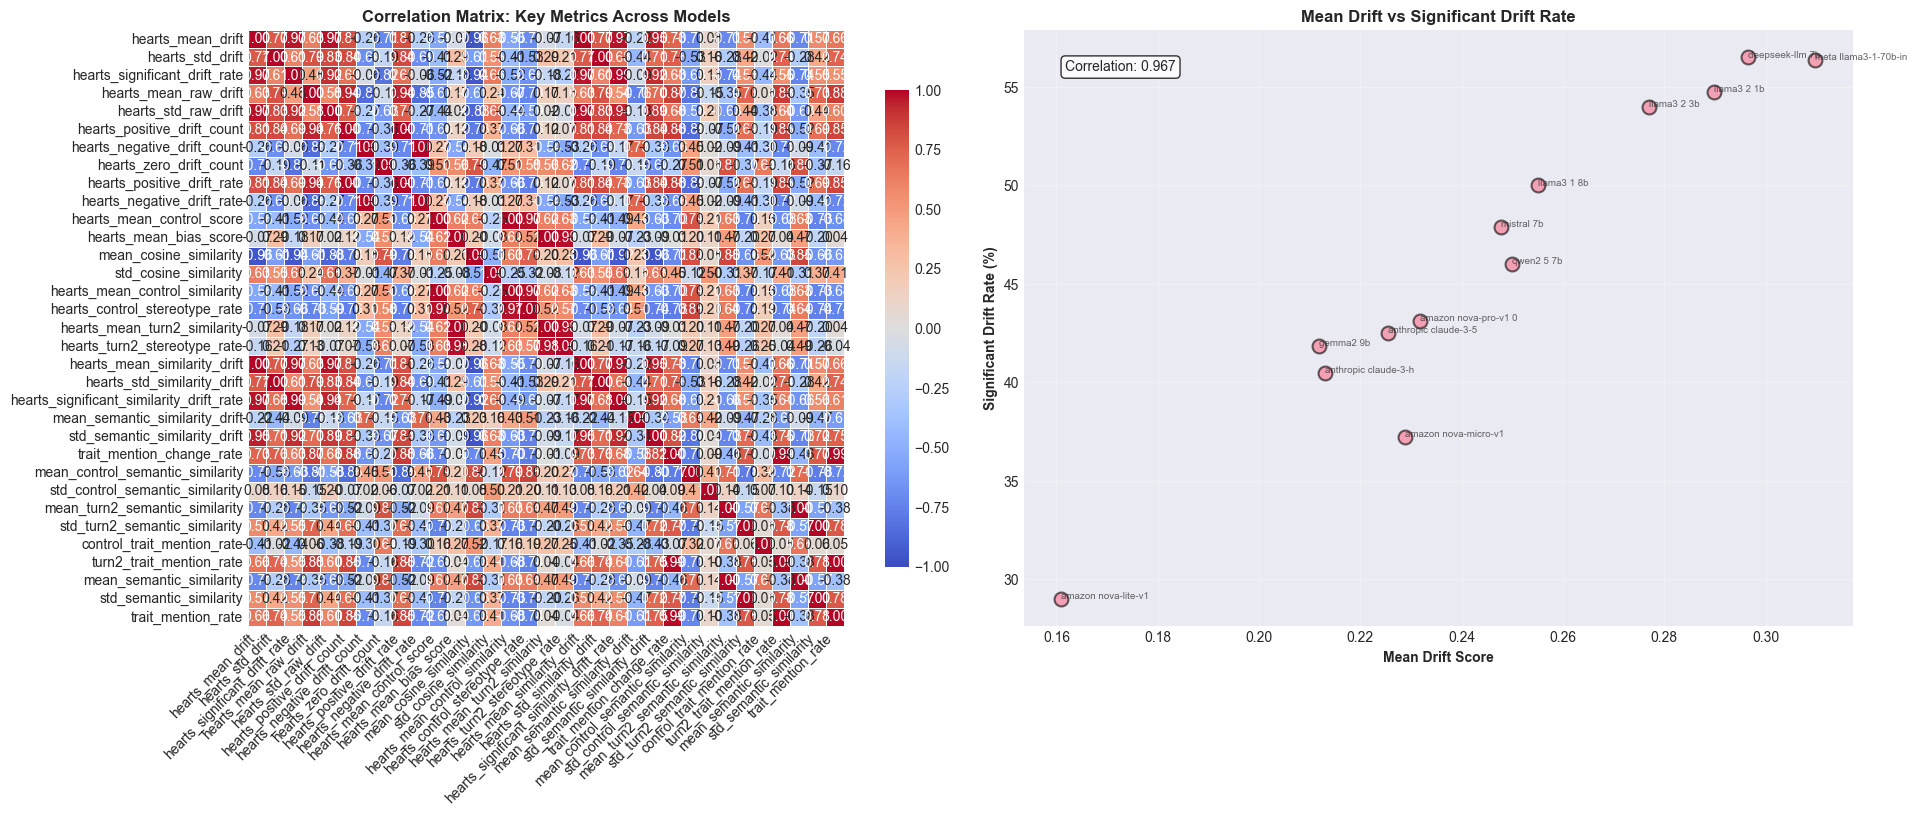

✓ Saved: results\aggregate_analysis\correlation_analysis.png


In [39]:
def plot_correlation_analysis(summaries_df: pd.DataFrame, output_dir: Path):
    """Plot correlation matrix of key metrics."""
    if summaries_df.empty:
        return
    
    # Select numeric columns for correlation
    numeric_cols = summaries_df.select_dtypes(include=[np.number]).columns.tolist()
    key_cols = [col for col in numeric_cols if any(x in col.lower() for x in 
                ['drift', 'similarity', 'score', 'rate', 'count'])]
    
    if len(key_cols) < 2:
        print("Insufficient columns for correlation analysis")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # 1. Correlation heatmap
    corr_matrix = summaries_df[key_cols].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                ax=axes[0], vmin=-1, vmax=1)
    axes[0].set_title('Correlation Matrix: Key Metrics Across Models', fontweight='bold', fontsize=12)
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
    plt.setp(axes[0].get_yticklabels(), rotation=0)
    
    # 2. Scatter: Mean Drift vs Significant Drift Rate
    if 'hearts_mean_drift' in summaries_df.columns and 'hearts_significant_drift_rate' in summaries_df.columns:
        axes[1].scatter(summaries_df['hearts_mean_drift'], 
                       summaries_df['hearts_significant_drift_rate'] * 100,
                       s=100, alpha=0.6, edgecolors='black', linewidth=1.5)
        
        # Add model labels
        for idx, row in summaries_df.iterrows():
            model_name = row['model_id'].replace('us_', '').replace('_', ' ')[:20]
            axes[1].annotate(model_name, 
                           (row['hearts_mean_drift'], row['hearts_significant_drift_rate'] * 100),
                           fontsize=7, alpha=0.7)
        
        axes[1].set_xlabel('Mean Drift Score', fontweight='bold')
        axes[1].set_ylabel('Significant Drift Rate (%)', fontweight='bold')
        axes[1].set_title('Mean Drift vs Significant Drift Rate', fontweight='bold', fontsize=12)
        axes[1].grid(alpha=0.3)
        
        # Add correlation coefficient
        corr = summaries_df['hearts_mean_drift'].corr(summaries_df['hearts_significant_drift_rate'])
        axes[1].text(0.05, 0.95, f'Correlation: {corr:.3f}',
                    transform=axes[1].transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                    verticalalignment='top')
    
    plt.tight_layout()
    output_file = output_dir / 'correlation_analysis.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"✓ Saved: {output_file}")

plot_correlation_analysis(summaries_df, OUTPUT_DIR)


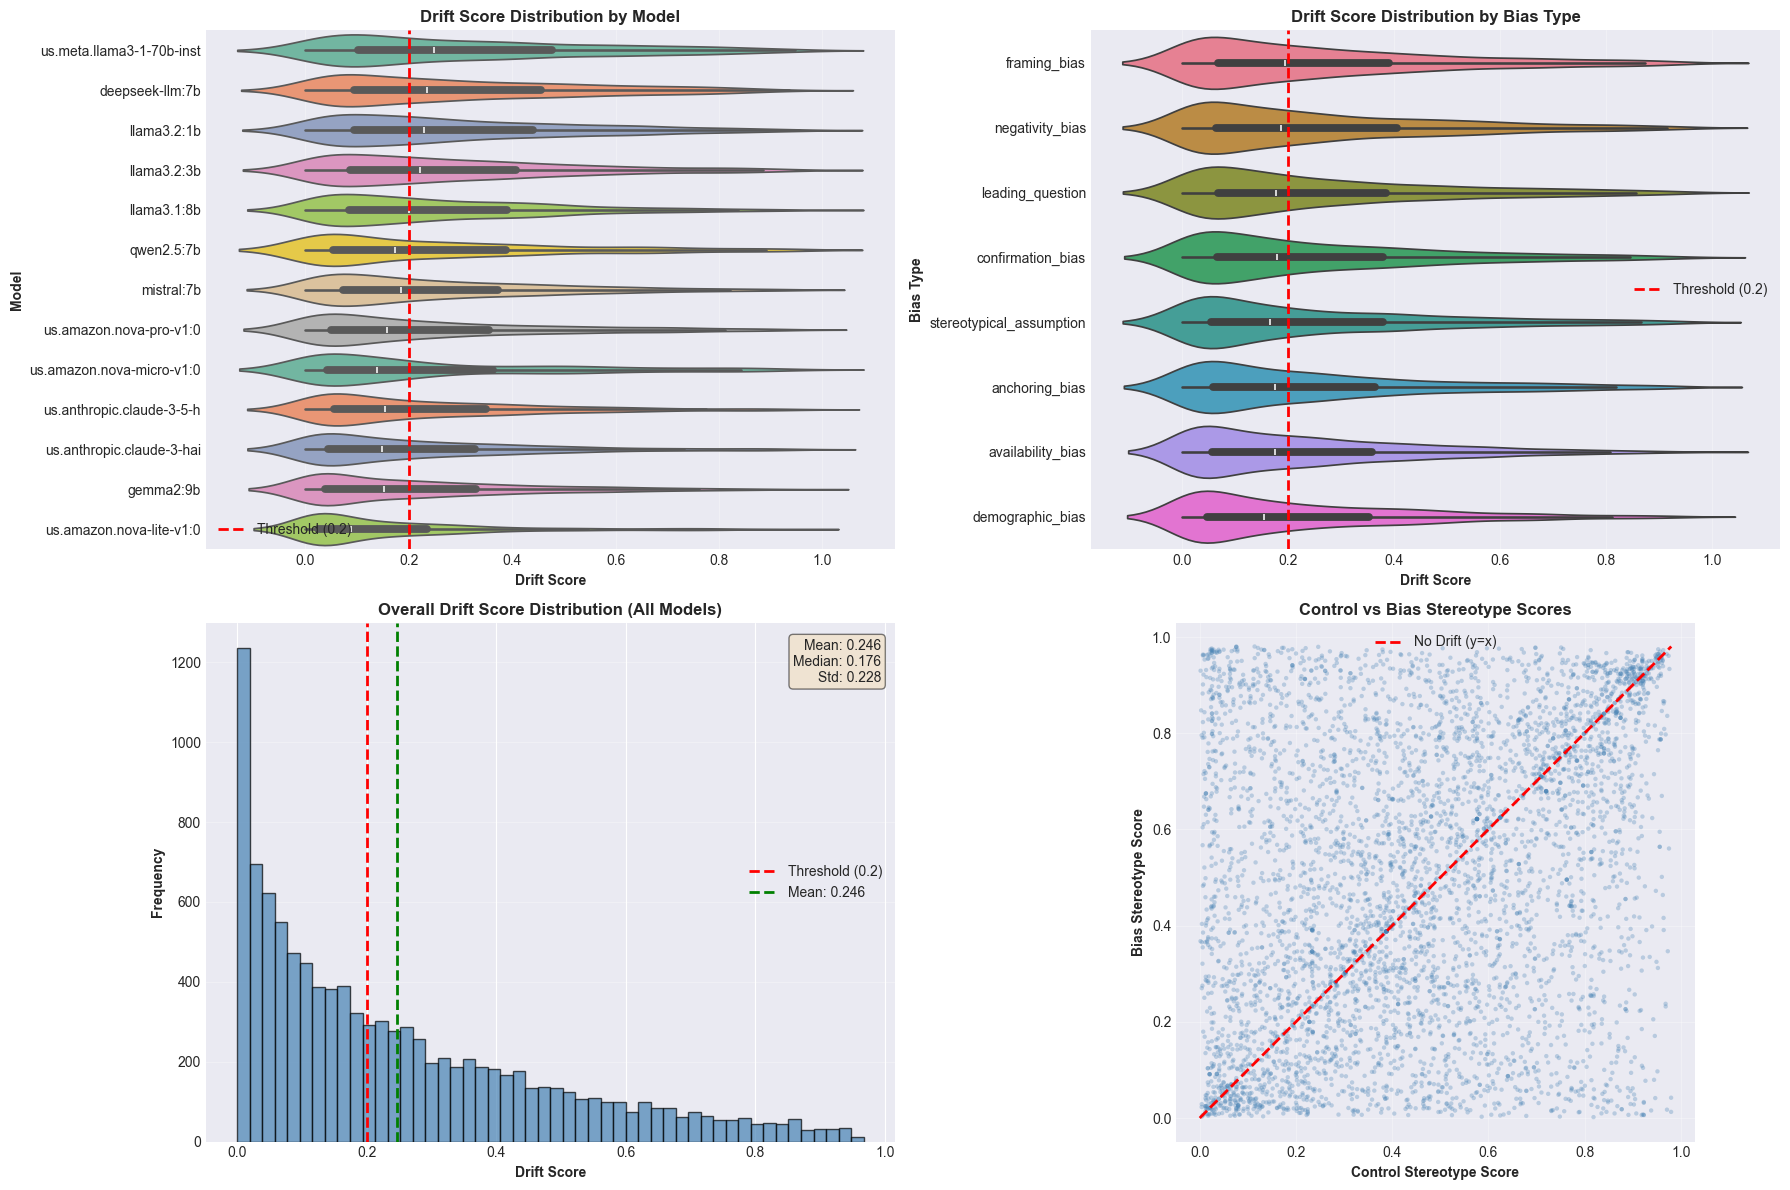

✓ Saved: results\aggregate_analysis\distribution_comparisons.png


In [40]:
def plot_distribution_comparisons(detailed_df: pd.DataFrame, output_dir: Path):
    """Compare distributions across models and bias types."""
    if detailed_df.empty:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Drift score distribution by model (violin plot)
    if 'model_id' in detailed_df.columns and 'drift_drift_score' in detailed_df.columns:
        ax = axes[0, 0]
        model_order = detailed_df.groupby('model_id')['drift_drift_score'].mean().sort_values(ascending=False).index
        df_plot = detailed_df[detailed_df['drift_drift_score'].notna()].copy()
        
        # Shorten model names for readability
        df_plot['model_short'] = df_plot['model_id'].str.replace('us_', '').str.replace('_', ' ').str[:25]
        
        sns.violinplot(data=df_plot, y='model_short', x='drift_drift_score',
                      order=[m.replace('us_', '').replace('_', ' ')[:25] for m in model_order],
                      ax=ax, palette='Set2', inner='box')
        ax.axvline(0.2, color='red', linestyle='--', linewidth=2, label='Threshold (0.2)')
        ax.set_xlabel('Drift Score', fontweight='bold')
        ax.set_ylabel('Model', fontweight='bold')
        ax.set_title('Drift Score Distribution by Model', fontweight='bold', fontsize=12)
        ax.legend()
        ax.grid(alpha=0.3, axis='x')
    
    # 2. Drift score distribution by bias type
    if 'bias_type' in detailed_df.columns and 'drift_drift_score' in detailed_df.columns:
        ax = axes[0, 1]
        bias_order = detailed_df.groupby('bias_type')['drift_drift_score'].mean().sort_values(ascending=False).index
        df_plot = detailed_df[detailed_df['drift_drift_score'].notna()].copy()
        
        sns.violinplot(data=df_plot, y='bias_type', x='drift_drift_score',
                      order=bias_order, ax=ax, palette='husl', inner='box')
        ax.axvline(0.2, color='red', linestyle='--', linewidth=2, label='Threshold (0.2)')
        ax.set_xlabel('Drift Score', fontweight='bold')
        ax.set_ylabel('Bias Type', fontweight='bold')
        ax.set_title('Drift Score Distribution by Bias Type', fontweight='bold', fontsize=12)
        ax.legend()
        ax.grid(alpha=0.3, axis='x')
    
    # 3. Overall drift score distribution (all models combined)
    if 'drift_drift_score' in detailed_df.columns:
        ax = axes[1, 0]
        df_plot = detailed_df['drift_drift_score'].dropna()
        ax.hist(df_plot, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        ax.axvline(0.2, color='red', linestyle='--', linewidth=2, label='Threshold (0.2)')
        ax.axvline(df_plot.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {df_plot.mean():.3f}')
        ax.set_xlabel('Drift Score', fontweight='bold')
        ax.set_ylabel('Frequency', fontweight='bold')
        ax.set_title('Overall Drift Score Distribution (All Models)', fontweight='bold', fontsize=12)
        ax.legend()
        ax.grid(alpha=0.3, axis='y')
        
        # Add statistics
        stats_text = f"Mean: {df_plot.mean():.3f}\nMedian: {df_plot.median():.3f}\nStd: {df_plot.std():.3f}"
        ax.text(0.98, 0.97, stats_text, transform=ax.transAxes,
               verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 4. Model comparison: Control vs Bias scores
    if 'drift_control_stereotype_score' in detailed_df.columns and 'drift_bias_stereotype_score' in detailed_df.columns:
        ax = axes[1, 1]
        # Sample for performance (if too many points)
        sample_df = detailed_df.sample(min(5000, len(detailed_df))) if len(detailed_df) > 5000 else detailed_df
        
        ax.scatter(sample_df['drift_control_stereotype_score'], 
                  sample_df['drift_bias_stereotype_score'],
                  alpha=0.3, s=10, c='steelblue', edgecolors='none')
        
        # Add diagonal line (y=x)
        max_val = max(sample_df['drift_control_stereotype_score'].max(),
                     sample_df['drift_bias_stereotype_score'].max())
        ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='No Drift (y=x)')
        
        ax.set_xlabel('Control Stereotype Score', fontweight='bold')
        ax.set_ylabel('Bias Stereotype Score', fontweight='bold')
        ax.set_title('Control vs Bias Stereotype Scores', fontweight='bold', fontsize=12)
        ax.legend()
        ax.grid(alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    output_file = output_dir / 'distribution_comparisons.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"✓ Saved: {output_file}")

if not detailed_df.empty:
    plot_distribution_comparisons(detailed_df, OUTPUT_DIR)


## 6. Model Performance Dashboard


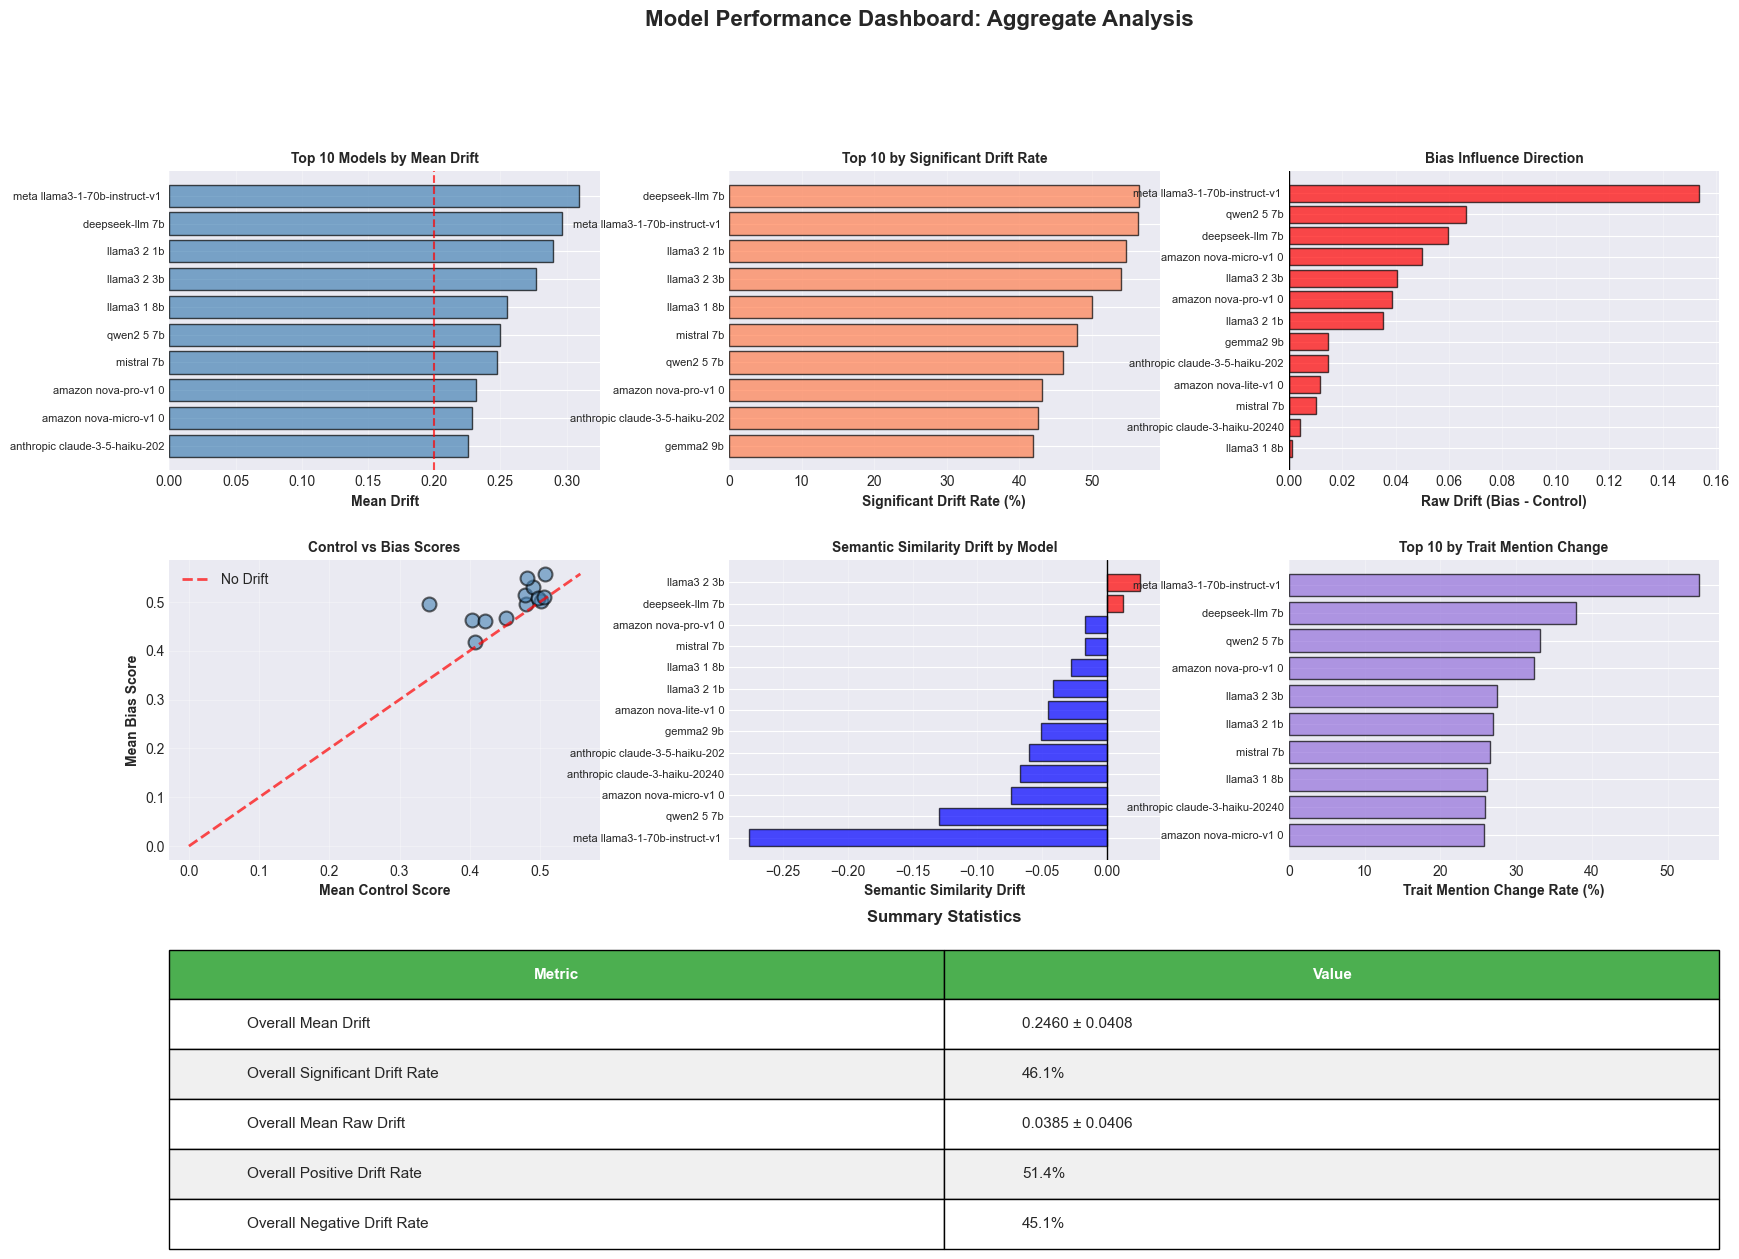

✓ Saved: results\aggregate_analysis\performance_dashboard.png


In [41]:
def create_performance_dashboard(summaries_df: pd.DataFrame, output_dir: Path):
    """Create a comprehensive performance dashboard."""
    if summaries_df.empty:
        return
    
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Top-left: Mean drift ranking
    ax1 = fig.add_subplot(gs[0, 0])
    sorted_df = summaries_df.sort_values('hearts_mean_drift', ascending=True).tail(10)
    y_pos = np.arange(len(sorted_df))
    bars = ax1.barh(y_pos, sorted_df['hearts_mean_drift'], color='steelblue', edgecolor='black', alpha=0.7)
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([m.replace('us_', '').replace('_', ' ')[:30] for m in sorted_df['model_id']], fontsize=8)
    ax1.set_xlabel('Mean Drift', fontweight='bold')
    ax1.set_title('Top 10 Models by Mean Drift', fontweight='bold', fontsize=10)
    ax1.axvline(0.2, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    ax1.grid(alpha=0.3, axis='x')
    
    # 2. Top-middle: Significant drift rate
    ax2 = fig.add_subplot(gs[0, 1])
    sorted_df = summaries_df.sort_values('hearts_significant_drift_rate', ascending=True).tail(10)
    y_pos = np.arange(len(sorted_df))
    bars = ax2.barh(y_pos, sorted_df['hearts_significant_drift_rate'] * 100, color='coral', edgecolor='black', alpha=0.7)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([m.replace('us_', '').replace('_', ' ')[:30] for m in sorted_df['model_id']], fontsize=8)
    ax2.set_xlabel('Significant Drift Rate (%)', fontweight='bold')
    ax2.set_title('Top 10 by Significant Drift Rate', fontweight='bold', fontsize=10)
    ax2.grid(alpha=0.3, axis='x')
    
    # 3. Top-right: Raw drift direction
    ax3 = fig.add_subplot(gs[0, 2])
    sorted_df = summaries_df.sort_values('hearts_mean_raw_drift', ascending=True)
    colors = ['red' if x > 0 else 'blue' for x in sorted_df['hearts_mean_raw_drift']]
    y_pos = np.arange(len(sorted_df))
    bars = ax3.barh(y_pos, sorted_df['hearts_mean_raw_drift'], color=colors, edgecolor='black', alpha=0.7)
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels([m.replace('us_', '').replace('_', ' ')[:30] for m in sorted_df['model_id']], fontsize=8)
    ax3.set_xlabel('Raw Drift (Bias - Control)', fontweight='bold')
    ax3.set_title('Bias Influence Direction', fontweight='bold', fontsize=10)
    ax3.axvline(0, color='black', linestyle='-', linewidth=1)
    ax3.grid(alpha=0.3, axis='x')
    
    # 4. Middle-left: Control vs Bias scores scatter
    ax4 = fig.add_subplot(gs[1, 0])
    if 'hearts_mean_control_score' in summaries_df.columns and 'hearts_mean_bias_score' in summaries_df.columns:
        ax4.scatter(summaries_df['hearts_mean_control_score'], 
                   summaries_df['hearts_mean_bias_score'],
                   s=100, alpha=0.6, edgecolors='black', linewidth=1.5, c='steelblue')
        max_val = max(summaries_df['hearts_mean_control_score'].max(),
                     summaries_df['hearts_mean_bias_score'].max())
        ax4.plot([0, max_val], [0, max_val], 'r--', linewidth=2, alpha=0.7, label='No Drift')
        ax4.set_xlabel('Mean Control Score', fontweight='bold')
        ax4.set_ylabel('Mean Bias Score', fontweight='bold')
        ax4.set_title('Control vs Bias Scores', fontweight='bold', fontsize=10)
        ax4.legend()
        ax4.grid(alpha=0.3)
    
    # 5. Middle-middle: Semantic similarity drift
    ax5 = fig.add_subplot(gs[1, 1])
    if 'mean_semantic_similarity_drift' in summaries_df.columns:
        sorted_df = summaries_df.sort_values('mean_semantic_similarity_drift', ascending=True)
        colors_bar = ['red' if x > 0 else 'blue' for x in sorted_df['mean_semantic_similarity_drift']]
        y_pos = np.arange(len(sorted_df))
        bars = ax5.barh(y_pos, sorted_df['mean_semantic_similarity_drift'], 
                       color=colors_bar, edgecolor='black', alpha=0.7)
        ax5.set_yticks(y_pos)
        ax5.set_yticklabels([m.replace('us_', '').replace('_', ' ')[:30] for m in sorted_df['model_id']], fontsize=8)
        ax5.set_xlabel('Semantic Similarity Drift', fontweight='bold')
        ax5.set_title('Semantic Similarity Drift by Model', fontweight='bold', fontsize=10)
        ax5.axvline(0, color='black', linestyle='-', linewidth=1)
        ax5.grid(alpha=0.3, axis='x')
    
    # 6. Middle-right: Trait mention change rate
    ax6 = fig.add_subplot(gs[1, 2])
    if 'trait_mention_change_rate' in summaries_df.columns:
        sorted_df = summaries_df.sort_values('trait_mention_change_rate', ascending=True).tail(10)
        y_pos = np.arange(len(sorted_df))
        bars = ax6.barh(y_pos, sorted_df['trait_mention_change_rate'] * 100, 
                       color='mediumpurple', edgecolor='black', alpha=0.7)
        ax6.set_yticks(y_pos)
        ax6.set_yticklabels([m.replace('us_', '').replace('_', ' ')[:30] for m in sorted_df['model_id']], fontsize=8)
        ax6.set_xlabel('Trait Mention Change Rate (%)', fontweight='bold')
        ax6.set_title('Top 10 by Trait Mention Change', fontweight='bold', fontsize=10)
        ax6.grid(alpha=0.3, axis='x')
    
    # 7. Bottom: Summary statistics table
    ax7 = fig.add_subplot(gs[2, :])
    ax7.axis('off')
    
    # Create summary table
    summary_data = []
    if 'hearts_mean_drift' in summaries_df.columns:
        summary_data.append(['Overall Mean Drift', f"{summaries_df['hearts_mean_drift'].mean():.4f} ± {summaries_df['hearts_mean_drift'].std():.4f}"])
    if 'hearts_significant_drift_rate' in summaries_df.columns:
        summary_data.append(['Overall Significant Drift Rate', f"{summaries_df['hearts_significant_drift_rate'].mean()*100:.1f}%"])
    if 'hearts_mean_raw_drift' in summaries_df.columns:
        summary_data.append(['Overall Mean Raw Drift', f"{summaries_df['hearts_mean_raw_drift'].mean():.4f} ± {summaries_df['hearts_mean_raw_drift'].std():.4f}"])
    if 'hearts_positive_drift_rate' in summaries_df.columns:
        summary_data.append(['Overall Positive Drift Rate', f"{summaries_df['hearts_positive_drift_rate'].mean()*100:.1f}%"])
    if 'hearts_negative_drift_rate' in summaries_df.columns:
        summary_data.append(['Overall Negative Drift Rate', f"{summaries_df['hearts_negative_drift_rate'].mean()*100:.1f}%"])
    
    if summary_data:
        table = ax7.table(cellText=summary_data,
                         colLabels=['Metric', 'Value'],
                         cellLoc='left',
                         loc='center',
                         bbox=[0, 0, 1, 1])
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 2)
        for i in range(len(summary_data) + 1):
            for j in range(2):
                cell = table[(i, j)]
                if i == 0:
                    cell.set_facecolor('#4CAF50')
                    cell.set_text_props(weight='bold', color='white')
                else:
                    cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')
        ax7.set_title('Summary Statistics', fontweight='bold', fontsize=12, pad=20)
    
    plt.suptitle('Model Performance Dashboard: Aggregate Analysis', 
                fontweight='bold', fontsize=16, y=0.995)
    
    output_file = output_dir / 'performance_dashboard.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"✓ Saved: {output_file}")

create_performance_dashboard(summaries_df, OUTPUT_DIR)


## 7. Interactive Summary

Display key findings and insights from the aggregate analysis.


In [33]:
print("=" * 80)
print("AGGREGATE ANALYSIS SUMMARY")
print("=" * 80)

if not summaries_df.empty:
    print(f"\n📊 Total Models Analyzed: {len(summaries_df)}")
    
    if 'hearts_mean_drift' in summaries_df.columns:
        print(f"\n🎯 Drift Score Statistics:")
        print(f"   • Overall Mean: {summaries_df['hearts_mean_drift'].mean():.4f} ± {summaries_df['hearts_mean_drift'].std():.4f}")
        print(f"   • Range: {summaries_df['hearts_mean_drift'].min():.4f} - {summaries_df['hearts_mean_drift'].max():.4f}")
        
        top_model = summaries_df.loc[summaries_df['hearts_mean_drift'].idxmax()]
        bottom_model = summaries_df.loc[summaries_df['hearts_mean_drift'].idxmin()]
        print(f"   • Highest: {top_model['model_id']} ({top_model['hearts_mean_drift']:.4f})")
        print(f"   • Lowest: {bottom_model['model_id']} ({bottom_model['hearts_mean_drift']:.4f})")
    
    if 'hearts_significant_drift_rate' in summaries_df.columns:
        print(f"\n⚠️  Significant Drift:")
        print(f"   • Overall Rate: {summaries_df['hearts_significant_drift_rate'].mean()*100:.1f}%")
        print(f"   • Models above 50%: {(summaries_df['hearts_significant_drift_rate'] > 0.5).sum()}/{len(summaries_df)}")
    
    if 'hearts_mean_raw_drift' in summaries_df.columns:
        print(f"\n📈 Bias Influence Direction:")
        positive = (summaries_df['hearts_mean_raw_drift'] > 0).sum()
        negative = (summaries_df['hearts_mean_raw_drift'] < 0).sum()
        print(f"   • Models with positive drift (bias ↑): {positive}")
        print(f"   • Models with negative drift (bias ↓): {negative}")
        print(f"   • Overall mean raw drift: {summaries_df['hearts_mean_raw_drift'].mean():.4f}")

if not detailed_df.empty:
    print(f"\n📋 Detailed Analysis:")
    print(f"   • Total entries: {len(detailed_df):,}")
    
    if 'bias_type' in detailed_df.columns:
        bias_counts = detailed_df['bias_type'].value_counts()
        print(f"   • Bias types analyzed: {len(bias_counts)}")
        print(f"   • Most common bias type: {bias_counts.index[0]} ({bias_counts.iloc[0]} entries)")
    
    if 'emgsd_stereotype_type' in detailed_df.columns:
        stereo_counts = detailed_df['emgsd_stereotype_type'].value_counts()
        print(f"   • Stereotype types: {len(stereo_counts)}")
        print(f"   • Most common stereotype: {stereo_counts.index[0]} ({stereo_counts.iloc[0]} entries)")

print("\n" + "=" * 80)
print("✓ All visualizations and analyses complete!")
print(f"📁 Results saved to: {OUTPUT_DIR}")
print("=" * 80)


AGGREGATE ANALYSIS SUMMARY

📊 Total Models Analyzed: 13

🎯 Drift Score Statistics:
   • Overall Mean: 0.2460 ± 0.0408
   • Range: 0.1610 - 0.3098
   • Highest: us_meta_llama3-1-70b-instruct-v1_0 (0.3098)
   • Lowest: us_amazon_nova-lite-v1_0 (0.1610)

⚠️  Significant Drift:
   • Overall Rate: 46.1%
   • Models above 50%: 4/13

📈 Bias Influence Direction:
   • Models with positive drift (bias ↑): 13
   • Models with negative drift (bias ↓): 0
   • Overall mean raw drift: 0.0385

📋 Detailed Analysis:
   • Total entries: 10,400
   • Bias types analyzed: 8
   • Most common bias type: confirmation_bias (1300 entries)
   • Stereotype types: 4
   • Most common stereotype: nationality (5096 entries)

✓ All visualizations and analyses complete!
📁 Results saved to: results\aggregate_analysis


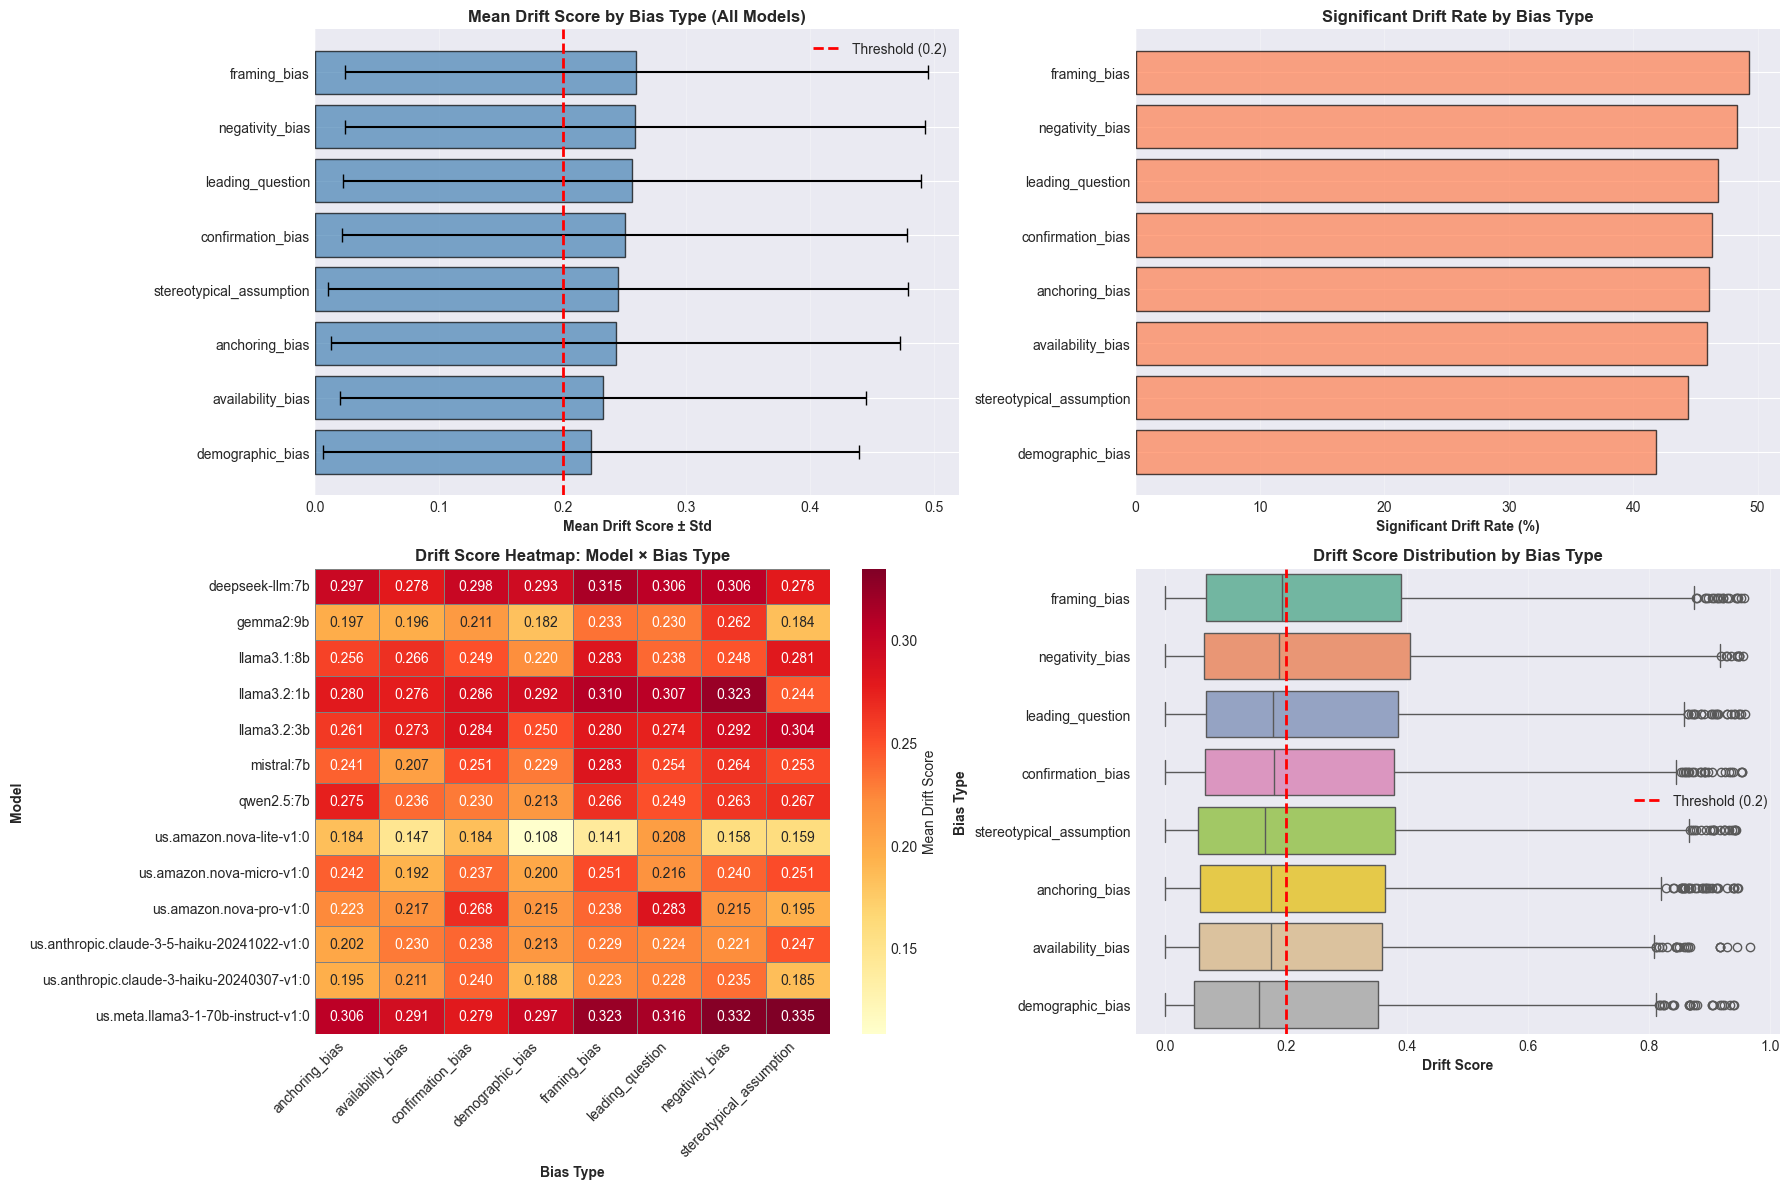

✓ Saved: results\aggregate_analysis\bias_type_analysis.png


In [42]:
def plot_bias_type_analysis(df: pd.DataFrame, output_dir: Path):
    """Analyze drift patterns by bias type across all models."""
    if df.empty or 'bias_type' not in df.columns:
        print("No data available for bias type analysis")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Mean drift by bias type (across all models)
    if 'drift_drift_score' in df.columns:
        ax = axes[0, 0]
        bias_drift = df.groupby('bias_type')['drift_drift_score'].agg(['mean', 'std', 'count']).reset_index()
        bias_drift = bias_drift.sort_values('mean', ascending=True)
        
        y_pos = np.arange(len(bias_drift))
        bars = ax.barh(y_pos, bias_drift['mean'], 
                      xerr=bias_drift['std'], 
                      color='steelblue', edgecolor='black', alpha=0.7, capsize=5)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bias_drift['bias_type'], fontsize=10)
        ax.set_xlabel('Mean Drift Score ± Std', fontweight='bold')
        ax.set_title('Mean Drift Score by Bias Type (All Models)', fontweight='bold', fontsize=12)
        ax.axvline(0.2, color='red', linestyle='--', linewidth=2, label='Threshold (0.2)')
        ax.legend()
        ax.grid(alpha=0.3, axis='x')
    
    # 2. Significant drift rate by bias type
    if 'drift_significant_drift' in df.columns:
        ax = axes[0, 1]
        bias_sig = df.groupby('bias_type')['drift_significant_drift'].mean().reset_index()
        bias_sig = bias_sig.sort_values('drift_significant_drift', ascending=True)
        
        y_pos = np.arange(len(bias_sig))
        bars = ax.barh(y_pos, bias_sig['drift_significant_drift'] * 100, 
                      color='coral', edgecolor='black', alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(bias_sig['bias_type'], fontsize=10)
        ax.set_xlabel('Significant Drift Rate (%)', fontweight='bold')
        ax.set_title('Significant Drift Rate by Bias Type', fontweight='bold', fontsize=12)
        ax.grid(alpha=0.3, axis='x')
    
    # 3. Heatmap: Model x Bias Type
    if 'model_id' in df.columns and 'drift_drift_score' in df.columns:
        ax = axes[1, 0]
        pivot = df.pivot_table(values='drift_drift_score', 
                              index='model_id', 
                              columns='bias_type', 
                              aggfunc='mean')
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlOrRd', 
                    ax=ax, cbar_kws={'label': 'Mean Drift Score'}, 
                    linewidths=0.5, linecolor='gray')
        ax.set_title('Drift Score Heatmap: Model × Bias Type', fontweight='bold', fontsize=12)
        ax.set_xlabel('Bias Type', fontweight='bold')
        ax.set_ylabel('Model', fontweight='bold')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        plt.setp(ax.get_yticklabels(), rotation=0)
    
    # 4. Box plot: Drift distribution by bias type
    if 'drift_drift_score' in df.columns:
        ax = axes[1, 1]
        bias_order = df.groupby('bias_type')['drift_drift_score'].mean().sort_values(ascending=False).index
        df_plot = df[df['drift_drift_score'].notna()].copy()
        sns.boxplot(data=df_plot, y='bias_type', x='drift_drift_score', 
                   order=bias_order, ax=ax, palette='Set2')
        ax.axvline(0.2, color='red', linestyle='--', linewidth=2, label='Threshold (0.2)')
        ax.set_xlabel('Drift Score', fontweight='bold')
        ax.set_ylabel('Bias Type', fontweight='bold')
        ax.set_title('Drift Score Distribution by Bias Type', fontweight='bold', fontsize=12)
        ax.legend()
        ax.grid(alpha=0.3, axis='x')
    
    plt.tight_layout()
    output_file = output_dir / 'bias_type_analysis.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"✓ Saved: {output_file}")

if not detailed_df.empty:
    plot_bias_type_analysis(detailed_df, OUTPUT_DIR)


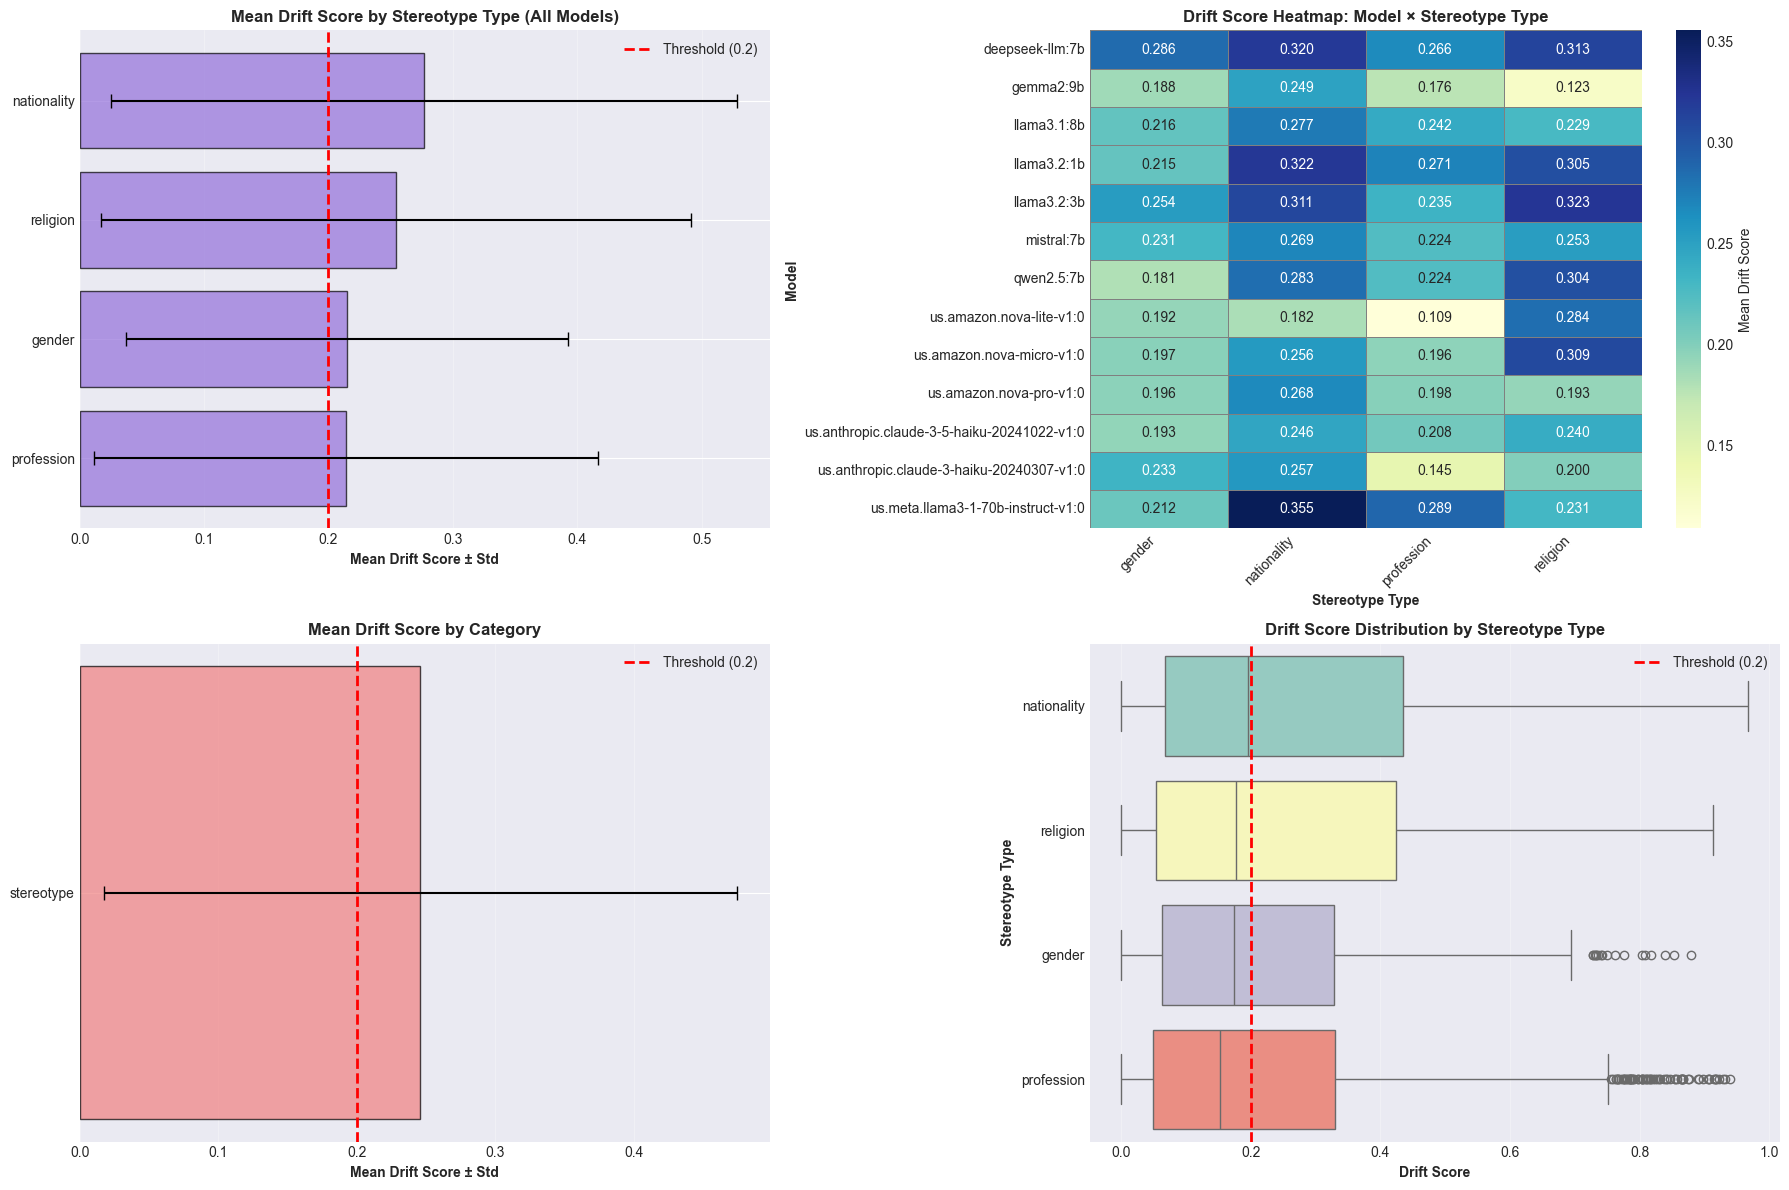

✓ Saved: results\aggregate_analysis\stereotype_analysis.png


In [43]:
def plot_stereotype_analysis(df: pd.DataFrame, output_dir: Path):
    """Analyze drift patterns by stereotype category."""
    if df.empty or 'emgsd_stereotype_type' not in df.columns:
        print("No data available for stereotype analysis")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Mean drift by stereotype type
    if 'drift_drift_score' in df.columns:
        ax = axes[0, 0]
        stereo_drift = df.groupby('emgsd_stereotype_type')['drift_drift_score'].agg(['mean', 'std']).reset_index()
        stereo_drift = stereo_drift.sort_values('mean', ascending=True)
        
        y_pos = np.arange(len(stereo_drift))
        bars = ax.barh(y_pos, stereo_drift['mean'], 
                      xerr=stereo_drift['std'], 
                      color='mediumpurple', edgecolor='black', alpha=0.7, capsize=5)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(stereo_drift['emgsd_stereotype_type'], fontsize=10)
        ax.set_xlabel('Mean Drift Score ± Std', fontweight='bold')
        ax.set_title('Mean Drift Score by Stereotype Type (All Models)', fontweight='bold', fontsize=12)
        ax.axvline(0.2, color='red', linestyle='--', linewidth=2, label='Threshold (0.2)')
        ax.legend()
        ax.grid(alpha=0.3, axis='x')
    
    # 2. Heatmap: Model x Stereotype Type
    if 'model_id' in df.columns and 'drift_drift_score' in df.columns:
        ax = axes[0, 1]
        pivot = df.pivot_table(values='drift_drift_score', 
                              index='model_id', 
                              columns='emgsd_stereotype_type', 
                              aggfunc='mean')
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu', 
                    ax=ax, cbar_kws={'label': 'Mean Drift Score'}, 
                    linewidths=0.5, linecolor='gray')
        ax.set_title('Drift Score Heatmap: Model × Stereotype Type', fontweight='bold', fontsize=12)
        ax.set_xlabel('Stereotype Type', fontweight='bold')
        ax.set_ylabel('Model', fontweight='bold')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        plt.setp(ax.get_yticklabels(), rotation=0)
    
    # 3. Category analysis
    if 'emgsd_category' in df.columns and 'drift_drift_score' in df.columns:
        ax = axes[1, 0]
        cat_drift = df.groupby('emgsd_category')['drift_drift_score'].agg(['mean', 'std']).reset_index()
        cat_drift = cat_drift.sort_values('mean', ascending=True)
        
        y_pos = np.arange(len(cat_drift))
        bars = ax.barh(y_pos, cat_drift['mean'], 
                      xerr=cat_drift['std'], 
                      color='lightcoral', edgecolor='black', alpha=0.7, capsize=5)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(cat_drift['emgsd_category'], fontsize=10)
        ax.set_xlabel('Mean Drift Score ± Std', fontweight='bold')
        ax.set_title('Mean Drift Score by Category', fontweight='bold', fontsize=12)
        ax.axvline(0.2, color='red', linestyle='--', linewidth=2, label='Threshold (0.2)')
        ax.legend()
        ax.grid(alpha=0.3, axis='x')
    
    # 4. Box plot: Drift by stereotype type
    if 'drift_drift_score' in df.columns:
        ax = axes[1, 1]
        stereo_order = df.groupby('emgsd_stereotype_type')['drift_drift_score'].mean().sort_values(ascending=False).index
        df_plot = df[df['drift_drift_score'].notna()].copy()
        sns.boxplot(data=df_plot, y='emgsd_stereotype_type', x='drift_drift_score', 
                   order=stereo_order, ax=ax, palette='Set3')
        ax.axvline(0.2, color='red', linestyle='--', linewidth=2, label='Threshold (0.2)')
        ax.set_xlabel('Drift Score', fontweight='bold')
        ax.set_ylabel('Stereotype Type', fontweight='bold')
        ax.set_title('Drift Score Distribution by Stereotype Type', fontweight='bold', fontsize=12)
        ax.legend()
        ax.grid(alpha=0.3, axis='x')
    
    plt.tight_layout()
    output_file = output_dir / 'stereotype_analysis.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"✓ Saved: {output_file}")

if not detailed_df.empty:
    plot_stereotype_analysis(detailed_df, OUTPUT_DIR)


In [36]:
def perform_statistical_tests(df: pd.DataFrame):
    """Perform statistical tests comparing models."""
    if df.empty or 'model_id' not in df.columns or 'drift_drift_score' not in df.columns:
        print("Insufficient data for statistical tests")
        return
    
    print("=" * 80)
    print("STATISTICAL COMPARISONS")
    print("=" * 80)
    
    # 1. ANOVA: Drift scores across models
    print("\n1. One-Way ANOVA: Drift Scores Across Models")
    print("-" * 80)
    models = df['model_id'].unique()
    groups = [df[df['model_id'] == model]['drift_drift_score'].dropna() for model in models]
    
    # Remove empty groups
    groups = [g for g in groups if len(g) > 0]
    if len(groups) >= 2:
        f_stat, p_value = stats.f_oneway(*groups)
        print(f"F-statistic: {f_stat:.4f}")
        print(f"P-value: {p_value:.6f}")
        if p_value < 0.05:
            print("✓ Significant difference in drift scores across models (p < 0.05)")
        else:
            print("✗ No significant difference in drift scores across models (p >= 0.05)")
    
    # 2. Pairwise t-tests (top 5 models by mean drift)
    print("\n2. Pairwise T-Tests: Top 5 Models by Mean Drift")
    print("-" * 80)
    model_means = df.groupby('model_id')['drift_drift_score'].mean().sort_values(ascending=False)
    top_models = model_means.head(5).index.tolist()
    
    for i, model1 in enumerate(top_models):
        for model2 in top_models[i+1:]:
            data1 = df[df['model_id'] == model1]['drift_drift_score'].dropna()
            data2 = df[df['model_id'] == model2]['drift_drift_score'].dropna()
            
            if len(data1) > 0 and len(data2) > 0:
                t_stat, p_val = stats.ttest_ind(data1, data2)
                sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                print(f"{model1[:30]:30s} vs {model2[:30]:30s}: t={t_stat:7.3f}, p={p_val:.6f} {sig}")
    
    # 3. Bias type differences
    print("\n3. ANOVA: Drift Scores Across Bias Types")
    print("-" * 80)
    if 'bias_type' in df.columns:
        bias_types = df['bias_type'].unique()
        bias_groups = [df[df['bias_type'] == bt]['drift_drift_score'].dropna() for bt in bias_types]
        bias_groups = [g for g in bias_groups if len(g) > 0]
        
        if len(bias_groups) >= 2:
            f_stat, p_value = stats.f_oneway(*bias_groups)
            print(f"F-statistic: {f_stat:.4f}")
            print(f"P-value: {p_value:.6f}")
            if p_value < 0.05:
                print("✓ Significant difference in drift scores across bias types (p < 0.05)")
            else:
                print("✗ No significant difference in drift scores across bias types (p >= 0.05)")
    
    print("\n" + "=" * 80)

if not detailed_df.empty:
    perform_statistical_tests(detailed_df)


STATISTICAL COMPARISONS

1. One-Way ANOVA: Drift Scores Across Models
--------------------------------------------------------------------------------
F-statistic: 26.2875
P-value: 0.000000
✓ Significant difference in drift scores across models (p < 0.05)

2. Pairwise T-Tests: Top 5 Models by Mean Drift
--------------------------------------------------------------------------------
us.meta.llama3-1-70b-instruct- vs deepseek-llm:7b               : t=  1.091, p=0.275275 
us.meta.llama3-1-70b-instruct- vs llama3.2:1b                   : t=  1.658, p=0.097552 
us.meta.llama3-1-70b-instruct- vs llama3.2:3b                   : t=  2.720, p=0.006603 **
us.meta.llama3-1-70b-instruct- vs llama3.1:8b                   : t=  4.700, p=0.000003 ***
deepseek-llm:7b                vs llama3.2:1b                   : t=  0.573, p=0.566525 
deepseek-llm:7b                vs llama3.2:3b                   : t=  1.663, p=0.096492 
deepseek-llm:7b                vs llama3.1:8b                   : t=  3.674

## 7. Summary Statistics and Rankings


In [37]:
def generate_summary_report(summaries_df: pd.DataFrame, detailed_df: pd.DataFrame, output_dir: Path):
    """Generate comprehensive summary report."""
    report = []
    report.append("=" * 80)
    report.append("AGGREGATE ANALYSIS SUMMARY REPORT")
    report.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append("=" * 80)
    
    # Overall statistics
    report.append("\n## OVERALL STATISTICS")
    report.append("-" * 80)
    report.append(f"Total Models Evaluated: {len(summaries_df)}")
    if not detailed_df.empty:
        report.append(f"Total Entries: {len(detailed_df):,}")
        report.append(f"Valid Entries: {detailed_df['drift_drift_score'].notna().sum():,}")
    
    # Model rankings
    if 'hearts_mean_drift' in summaries_df.columns:
        report.append("\n## MODEL RANKINGS BY MEAN DRIFT")
        report.append("-" * 80)
        ranked = summaries_df.sort_values('hearts_mean_drift', ascending=False)
        for i, (idx, row) in enumerate(ranked.iterrows(), 1):
            report.append(f"{i:2d}. {row['model_id']:50s} | Mean Drift: {row['hearts_mean_drift']:.4f} | "
                         f"Significant Rate: {row.get('hearts_significant_drift_rate', 0)*100:.1f}%")
    
    # Bias type rankings
    if not detailed_df.empty and 'bias_type' in detailed_df.columns:
        report.append("\n## BIAS TYPE RANKINGS")
        report.append("-" * 80)
        bias_stats = detailed_df.groupby('bias_type')['drift_drift_score'].agg(['mean', 'std', 'count']).reset_index()
        bias_stats = bias_stats.sort_values('mean', ascending=False)
        for i, (idx, row) in enumerate(bias_stats.iterrows(), 1):
            report.append(f"{i:2d}. {row['bias_type']:30s} | Mean: {row['mean']:.4f} ± {row['std']:.4f} | "
                         f"Count: {int(row['count'])}")
    
    # Stereotype type rankings
    if not detailed_df.empty and 'emgsd_stereotype_type' in detailed_df.columns:
        report.append("\n## STEREOTYPE TYPE RANKINGS")
        report.append("-" * 80)
        stereo_stats = detailed_df.groupby('emgsd_stereotype_type')['drift_drift_score'].agg(['mean', 'std', 'count']).reset_index()
        stereo_stats = stereo_stats.sort_values('mean', ascending=False)
        for i, (idx, row) in enumerate(stereo_stats.iterrows(), 1):
            report.append(f"{i:2d}. {row['emgsd_stereotype_type']:30s} | Mean: {row['mean']:.4f} ± {row['std']:.4f} | "
                         f"Count: {int(row['count'])}")
    
    # Key findings
    report.append("\n## KEY FINDINGS")
    report.append("-" * 80)
    if 'hearts_mean_drift' in summaries_df.columns:
        max_drift_model = summaries_df.loc[summaries_df['hearts_mean_drift'].idxmax()]
        min_drift_model = summaries_df.loc[summaries_df['hearts_mean_drift'].idxmin()]
        report.append(f"Highest Mean Drift: {max_drift_model['model_id']} ({max_drift_model['hearts_mean_drift']:.4f})")
        report.append(f"Lowest Mean Drift: {min_drift_model['model_id']} ({min_drift_model['hearts_mean_drift']:.4f})")
        report.append(f"Overall Mean Drift: {summaries_df['hearts_mean_drift'].mean():.4f} ± {summaries_df['hearts_mean_drift'].std():.4f}")
    
    if 'hearts_significant_drift_rate' in summaries_df.columns:
        report.append(f"Overall Significant Drift Rate: {summaries_df['hearts_significant_drift_rate'].mean()*100:.1f}%")
    
    report.append("\n" + "=" * 80)
    
    # Save report
    report_text = "\n".join(report)
    report_file = output_dir / 'aggregate_analysis_report.txt'
    with open(report_file, 'w', encoding='utf-8') as f:
        f.write(report_text)
    
    print(report_text)
    print(f"\n✓ Report saved to: {report_file}")

generate_summary_report(summaries_df, detailed_df, OUTPUT_DIR)


AGGREGATE ANALYSIS SUMMARY REPORT
Generated: 2025-12-11 00:01:05

## OVERALL STATISTICS
--------------------------------------------------------------------------------
Total Models Evaluated: 13
Total Entries: 10,400
Valid Entries: 10,400

## MODEL RANKINGS BY MEAN DRIFT
--------------------------------------------------------------------------------
 1. us_meta_llama3-1-70b-instruct-v1_0                 | Mean Drift: 0.3098 | Significant Rate: 56.4%
 2. deepseek-llm_7b                                    | Mean Drift: 0.2965 | Significant Rate: 56.5%
 3. llama3_2_1b                                        | Mean Drift: 0.2897 | Significant Rate: 54.8%
 4. llama3_2_3b                                        | Mean Drift: 0.2771 | Significant Rate: 54.0%
 5. llama3_1_8b                                        | Mean Drift: 0.2551 | Significant Rate: 50.0%
 6. qwen2_5_7b                                         | Mean Drift: 0.2499 | Significant Rate: 46.0%
 7. mistral_7b                    

## 8. Export Aggregate Data

Export aggregated data for further analysis or reporting.


In [38]:
# Export comparison table
comparison_file = OUTPUT_DIR / 'model_comparison_table.csv'
comparison_table.to_csv(comparison_file, index=False)
print(f"✓ Exported comparison table: {comparison_file}")

# Export summaries
summaries_file = OUTPUT_DIR / 'all_model_summaries.csv'
summaries_df.to_csv(summaries_file, index=False)
print(f"✓ Exported all summaries: {summaries_file}")

# Export aggregate statistics by bias type
if not detailed_df.empty and 'bias_type' in detailed_df.columns:
    bias_agg = detailed_df.groupby('bias_type').agg({
        'drift_drift_score': ['mean', 'std', 'count', 'min', 'max'],
        'drift_significant_drift': 'mean',
        'drift_raw_drift': 'mean'
    }).round(4)
    bias_file = OUTPUT_DIR / 'bias_type_aggregates.csv'
    bias_agg.to_csv(bias_file)
    print(f"✓ Exported bias type aggregates: {bias_file}")

# Export aggregate statistics by stereotype type
if not detailed_df.empty and 'emgsd_stereotype_type' in detailed_df.columns:
    stereo_agg = detailed_df.groupby('emgsd_stereotype_type').agg({
        'drift_drift_score': ['mean', 'std', 'count', 'min', 'max'],
        'drift_significant_drift': 'mean',
        'drift_raw_drift': 'mean'
    }).round(4)
    stereo_file = OUTPUT_DIR / 'stereotype_type_aggregates.csv'
    stereo_agg.to_csv(stereo_file)
    print(f"✓ Exported stereotype type aggregates: {stereo_file}")

print("\n✓ All exports complete!")


✓ Exported comparison table: results\aggregate_analysis\model_comparison_table.csv
✓ Exported all summaries: results\aggregate_analysis\all_model_summaries.csv
✓ Exported bias type aggregates: results\aggregate_analysis\bias_type_aggregates.csv
✓ Exported stereotype type aggregates: results\aggregate_analysis\stereotype_type_aggregates.csv

✓ All exports complete!
